## Brachistochrone Curve

For reference, c.f. [here](https://baike.baidu.com/item/%E6%9C%80%E9%80%9F%E9%99%8D%E7%BA%BF%E9%97%AE%E9%A2%98).

Another code for this problem (also in TensorFlow) can be found [herein](https://github.com/yimuw/Let-Tensor-Flow/blob/master/control/brachistochrone_curve.py).

For a trajectory $y(x)$ for $\forall x \in [0, 1]$, the action (loss), as the total time spent, is given by
\begin{equation}
  \mathcal{L}[y] = \int_{x_0}^{x_1} d x 
                   \frac{ \sqrt{ 1 + {y^{\prime}}^2 (x) } } { \sqrt{ 2 g \left( y_0 - y(x) \right) } },
\end{equation}
with boundary condition
$$ y(x_0) = y_0 \;, y(x_1) = y_1 , $$
where $g$ is the gravitational constant and $y_0 > y_1$.

Employ Monte-Carlo approximation. Let $\{ x_i: i = 1, \ldots, N \} \sim \text{Uniform}(x_0, x_1)$, the action with boundary condition and penalty becomes
\begin{equation}
  \mathcal{L}[y] = \frac{1}{N} \sum_{i=1}^{N}
                   \frac{ \sqrt{ 1 + {y^{\prime}}^2 (x_i) } }{ \sqrt{ 2 g \left( y_0 - y(x_i) \right) } }
                   + \frac{1}{2} \sum_{ x_b \in \{x_0, x_1\} } d(y(x_b)), 
\end{equation}
with some pre-defined distance $d$.

In [1]:
%matplotlib notebook

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from datetime import datetime
from collections import namedtuple
import random as rn
import os

# Global parameters
_SEED = 42
_EPSILON = 1e-8

# For reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(_SEED)
rn.seed(_SEED)
tf.set_random_seed(_SEED)

In [2]:
def make_neural_network(x, hidden_layers, output_shape, name=None):
  """Implement the generic neural network with the dense linear output
  layer.
  Args:
    x: Tensor-like, as the input of the neural network. It's shape is
        of `[batch_size] + x_shape`.
    hidden_layers: List of objects of the classes in `tf.layers`.
    output_shape: List of integers.
  Returns:
    The output tensor of the neural network.
  """
  with tf.name_scope(name, 'NeuralNetwork', [x]):
    x = tf.convert_to_tensor(x)
    
    # Hidden layers
    hidden = x  # initialize.
    for layer in hidden_layers:
      hidden = layer(hidden)
    
    # Output layer
    flatten_hidden = tf.layers.flatten(hidden)
    output_size = sum(flatten(output_shape))
    output = tf.layers.dense(flatten_hidden, output_size)
    output = tf.reshape(output, [-1]+output_shape)

  return output


def flatten(nested_list):
    """Helper. (Recursively) flatten an arbitrarily nested list."""
    if nested_list == []:
        return nested_list
    if isinstance(nested_list[0], list):
        return flatten(nested_list[0]) + flatten(nested_list[1:])
    return nested_list[:1] + flatten(nested_list[1:])


def make_action(y_bulk, grad_y_bulk, y_0, g=9.8, epsilon=_EPSILON, name=None):
    """Implements the action in Monte-Carlo integral.
    
    The action is a Monte-Carlo integral IN THE BULK.
    
    Args:
      y: Tensor-like, with shape `[batch_size] + y_shape`.
      grad_y: Tensor-like, with shape `[batch_size] + y_shape`.
      y_0: Tensor-like, with shape `y_shape`.
      g: Scalar-like, as the gravitational constant, optional.
      epsilon: Scalar-like, for numerical stability, optional.
    Returns:
      Scalar.
    """
    with tf.name_scope(name, 'Action', [y_bulk, grad_y_bulk, y_0]):
      y_bulk = tf.convert_to_tensor(y_bulk)
      grad_y_bulk = tf.convert_to_tensor(grad_y_bulk)
      y_0 = tf.convert_to_tensor(y_0)
      # Add `batch_size`-dimension
      y_0 = tf.expand_dims(y_0, axis=0)
    
      with tf.name_scope('DeltaHeight'):
        delta_y = y_0 - y_bulk
        # Clip `delta_y` so as to keep it positive
        delta_y = tf.where(delta_y > 0.0, delta_y, tf.zeros_like(delta_y))
        
      with tf.name_scope('Lagrangian'):
        lagrangians = tf.truediv(
            tf.sqrt(1.0 + grad_y_bulk**2),
            tf.sqrt(2.0 * g * delta_y) + epsilon)
        
      action = tf.reduce_mean(lagrangians)
      return action


def make_boundary(y_boundary, target_y_boundary, n=4, lambda_=50.0, name=None):
  """Make the boundary term, vanishing of which makes the fitting of boundary.
  
  $ b(y, y_b) := \lambda * \norm{y - y_b}_n $
  
  Args:
    y_boundary: Tensor-like, with the shape `[n_boundary] + y_shape`, as the
        boundary given by the neural network, as the $y$.
    target_y_boundary: Tensor-like, with the shape `[n_boundary] + y_shape`,
        as the target boundary to fit, as the $y_b$.
    n: Positive integer, employ L-`n` norm.
    lambda: Positive float.
  Returns:
    Scalar.
  """
  with tf.name_scope(name, 'Boundary', [y_boundary, target_y_boundary]):
    y_boundary = tf.convert_to_tensor(y_boundary)
    target_y_boundary = tf.convert_to_tensor(target_y_boundary)
    # `delta` shall be vanishing
    delta = (y_boundary - target_y_boundary)
    boundary = lambda_ * l_n_norm(delta, n)
    return boundary


def l_n_norm(x, n, name=None):
  """L-`n` norm of tensor `x`."""
  with tf.name_scope(name, 'L{}_Norm'.format(n), [x]):
    x = tf.convert_to_tensor(x)
    norm = tf.reduce_mean(x**n)
    return norm


ResultOps = namedtuple('ResultOps',
    'loss, grad_y_bulk, y_bulk, y_boundary, action, boundary')


def make_loss(x_bulk, x_boundary, target_y_boundary, make_y,
              name=None):
  """Implements the loss.
  
  It is found that `loss = action * (1 + boundary)` is much more numerically
  stable and performs much better than `loss = action + boundary`.
  
  XXX: Why so?
  
  Args:
    x_bulk: Tensor-like, with shape `[batch_size] + x_shape`, as the
        non-boundary values of the input to the neural network.
    x_boundary: Tensor-like, with shape `[n_boundaries] + x_shape`, as
        the boundary values of the input to the neural network.
    target_y_boundary: Tensor-like, with the shape `[n_boundary] + y_shape`,
        as the target boundary to fit.
    make_y: Callable that maps `x` to the neural network output.
  Returns:
    Scalar.
  """
  with tf.name_scope(name, 'Loss',
        [x_bulk, x_boundary, target_y_boundary]):
    x_bulk = tf.convert_to_tensor(x_bulk)
    x_boundary = tf.convert_to_tensor(x_boundary)
    target_y_boundary = tf.convert_to_tensor(target_y_boundary)
    
    x = tf.concat([x_bulk, x_boundary], axis=0)
    y = make_y(x)

    batch_size = x_bulk.get_shape().as_list()[0]
    n_boundary = x_boundary.get_shape().as_list()[0]
    y_bulk, y_boundary = tf.split(y, [batch_size, n_boundary],
                                  axis=0)
    grad_y_bulk = tf.gradients(y_bulk, [x_bulk])[0]
    y_0 = tf.unstack(target_y_boundary, axis=0)[0]

    action = make_action(y_bulk, grad_y_bulk, y_0)
    boundary = make_boundary(y_boundary, target_y_boundary)
    #loss = action * (1 + boundary)
    loss = action + boundary

  return ResultOps(loss, grad_y_bulk, y_bulk, y_boundary, action, boundary)

In [3]:
def plot_frame(X, y, pause):
    """Helper. For dynamical plot.
    Args:
        X: Array-like.
        y: Array-like.
        pause: Float or `None`.
    """
    plt.plot(X, y)
    plt.draw()
    plt.axis('equal')
    if pause:
        plt.pause(0.01)
        plt.clf()


def l1_norm(x):
    """Helper. L1-norm."""
    return np.mean(np.abs(x))


def test():
    """TODO: make API."""

    # -- Build graph
    
    tf.reset_default_graph()

    x_dim = 1
    n_samples = 1000
    y_dim = 1

    x_bulk = tf.placeholder(shape=[n_samples, x_dim], dtype='float32',
                            name='x_bulk')
    x_boundary = np.array([[0.0], [3.0]], dtype='float32')
    target_y_boundary = np.array([[0.0], [-1.0]], dtype='float32')

    hidden_layers = []
    for i in range(5):
        hidden_layers += [
            lambda x: tf.layers.dense(
                x, 10, activation=tf.nn.sigmoid),
            lambda x: tf.layers.dropout(x),
        ]
            
    def make_y(x):
        return make_neural_network(x, hidden_layers, [y_dim])

    ops = make_loss(x_bulk, x_boundary, target_y_boundary, make_y)

    # For optimizing
    optimizer = tf.train.AdamOptimizer(0.01)
    train_op = optimizer.minimize(ops.loss)

    with tf.Session() as sess:
        
        # Initialize all `tf.Variable`s, explicit or implicit
        sess.run(tf.global_variables_initializer())

        # -- Optimizing

        # Parameters
        n_iters = 4*10**4

        def get_x_bulk_value():
            """For feed-dict."""
            x_bulk_value = -np.random.uniform(
                -x_boundary[1,0], -x_boundary[0,0], size=[n_samples, 1])
            x_bulk_value = x_bulk_value.astype('float32')
            x_bulk_value = np.sort(x_bulk_value, axis=0)
            return x_bulk_value
        
        # For visualization
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.ion()
        fig.show()
        fig.canvas.draw()

        # Iterations
        for i in range(n_iters):
            step = i + 1
            iter_ops = [train_op, ops.loss, ops.y_bulk, ops.grad_y_bulk,
                        ops.action, ops.boundary]
            x_bulk_value = get_x_bulk_value()
            result = sess.run(iter_ops, feed_dict={x_bulk: x_bulk_value})
            _, loss, y_bulk, grad_y_bulk, action, boundary = result

            if step % 100 == 0:
                # Visualization
                ax.clear()
                ax.plot(x_bulk_value, y_bulk)
                ax.set_title('{0} | {1:.3f} {2:.3f} {3:.3f}'\
                             .format(step, loss, action, boundary))
                fig.canvas.draw()
                #print(step, loss, action, boundary)

            # For debugging
            if np.isnan(loss):
                print(step, loss, action, boundary,
                      grad_y_bulk, x_bulk_value, y_bulk)
                plot_frame(x_bulk_value, y_bulk, pause=None)
                break

<IPython.core.display.Javascript object>


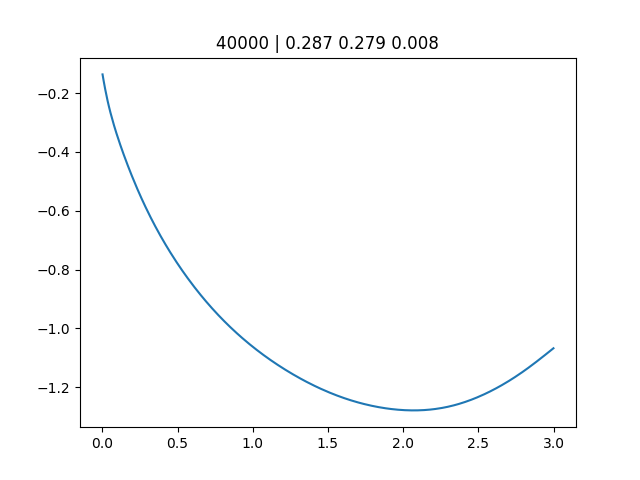

CPU times: user 4min 23s, sys: 12.8 s, total: 4min 36s
Wall time: 3min 49s


In [4]:
%%time
test()

TODO:
  * Compare with analytic result.
  * Coherent the numerical stability at boundary and the penalty to the boundary.